In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import calendar

# Big G notebook Part 3: Feature Selection and Model Preparation
This notebook will attempt to add some features to the dataset and establish encoding to help analyze time_series data

In [2]:
# Here's the pkl - 1,057,461 entries.
on_faults = pd.read_pickle('../data/on_faults.pkl')
on_faults.info()

# We only want active trucks
on_faults = on_faults[on_faults['active'] == True]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057461 entries, 0 to 1057460
Data columns (total 50 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RecordID                   1057461 non-null  int64         
 1   ESS_Id                     1057461 non-null  int64         
 2   EventTimeStamp             1057461 non-null  datetime64[ns]
 3   eventDescription           1006873 non-null  object        
 4   ecuSoftwareVersion         793094 non-null   object        
 5   ecuSerialNumber            751418 non-null   object        
 6   ecuModel                   1001485 non-null  object        
 7   ecuMake                    1001485 non-null  object        
 8   ecuSource                  1057461 non-null  int64         
 9   spn                        1057461 non-null  int64         
 10  fmi                        1057461 non-null  int64         
 11  active                     1057461 no

Potential Feature: the closest service center and its distance from the fault code.  Find the season of the year where the fault occured.

In [3]:
# Creating the min_distance_to_service_center feature
on_faults['dist_to_nearest_sc'] = on_faults[['dist_A', 'dist_B', 'dist_C']].min(axis=1)

# Creating the nearest_service_center feature
on_faults['nearest_sc'] = on_faults[['dist_A', 'dist_B', 'dist_C']].idxmin(axis=1)

# Dropping the 'dist_A', 'dist_B', and 'dist_C' columns
on_faults.drop(['dist_A', 'dist_B', 'dist_C'], axis=1, inplace=True)

# Removing the 'dist_' prefix from each value in the 'nearest_sc' column
on_faults['nearest_sc'] = on_faults['nearest_sc'].str.replace('dist_', '')

# Finding the season were the fault occured.
def get_season(month):
    if month in {3, 4, 5}:
        return 'Spring'
    elif month in {6, 7, 8}:
        return 'Summer'
    elif month in {9, 10, 11}:
        return 'Fall'
    else:
        return 'Winter'

# Extracting the month from EventTimeStamp
on_faults['month'] = on_faults['EventTimeStamp'].dt.month

# Creating the season feature based on the month
on_faults['season'] = on_faults['month'].apply(get_season)

# Dropping the month column, as it's not needed anymore
on_faults.drop('month', axis=1, inplace=True)

Information on Trucks that Have ever had a Full Derate

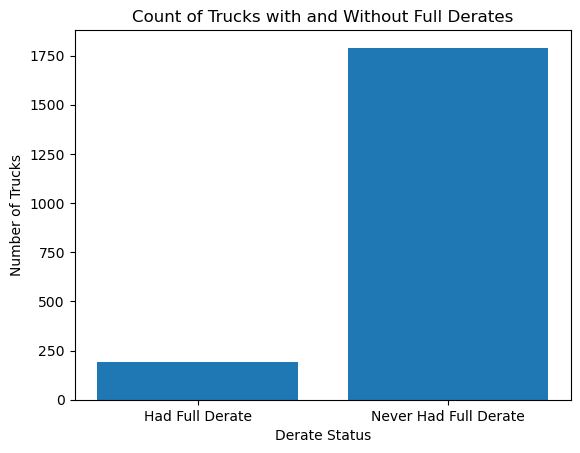

In [4]:
# Find unique EquipmentIDs for trucks that have ever experienced SPN = 5246 (full derate)
full_d = on_faults[on_faults['spn'] == 5246]['EquipmentID'].unique()

# Filter the entire dataset using the unique EquipmentIDs
had_full_d = on_faults[on_faults['EquipmentID'].isin(full_d)]

# Find unique EquipmentIDs for trucks that have NEVER experienced SPN = 5246 (full derate)
not_full_d = on_faults[on_faults['spn'] != 5246]['EquipmentID'].unique()

# Filter the entire dataset using the unique EquipmentIDs
never_had_full_d = on_faults[on_faults['EquipmentID'].isin(full_d)]

# Count the number of unique EquipmentIDs for each category
num_full_d = len(had_full_d['EquipmentID'].unique())
num_not_full_d = len(not_full_d)

# Create a bar chart to visualize the counts
plt.bar(['Had Full Derate', 'Never Had Full Derate'], [num_full_d, num_not_full_d])
plt.title('Count of Trucks with and Without Full Derates')
plt.xlabel('Derate Status')
plt.ylabel('Number of Trucks')
plt.show()

Create One-Hot Encoder for SPNs

In [13]:
# Drop "Unneccisary" columns - everything but Event time stamp, equiptment ID and TimeStamp.
rolling_faults = on_faults[['EventTimeStamp', 'EquipmentID', 'spn']]

# Create one-hot encoding of the SPN column
one_hot = pd.get_dummies(rolling_faults['spn'], prefix='SPN')

# Set index of the one_hot to the rolling_faults
one_hot.index = rolling_faults.index

# Concatenate rolling_faults with one_hot
one_hot_fault = pd.concat([rolling_faults, one_hot], axis=1)

# Drop the original SPN column
one_hot_fault.drop('spn', axis=1, inplace=True)

# Set the index to 'EventTimeStamp'
one_hot_fault.set_index('EquipmentID', inplace=True)

In [11]:
one_hot_fault

,EventTimeStamp,SPN_0,SPN_16,SPN_27,SPN_33,SPN_37,SPN_38,SPN_51,SPN_70,SPN_74,...,SPN_520413,SPN_520953,SPN_521032,SPN_523530,SPN_523531,SPN_523543,SPN_524033,SPN_524037,SPN_524071,SPN_524287
EquipmentID,,,,,,,,,,,,,,,,,,,,,
1439,2015-02-21 10:47:13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439,2015-02-21 11:34:34,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1369,2015-02-21 11:35:33,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1417,2015-02-21 11:40:22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1597,2015-02-21 11:40:52,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,2020-03-06 13:12:43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1886,2020-03-06 13:42:48,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1994,2020-03-06 14:04:23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Pickle the eda info so that I can start building models 

In [ ]:
one_hot_fault.to_pickle("../data/spn_only.pkl")